#### Seq2Seq Q&A Chatbot 구현

##### 데이터 취득

In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/refs/heads/master/ChatbotData.csv')
df = df[['Q', 'A']]

In [3]:
df

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.


##### 데이터 전처리

##### Tokenizer 학습 (sentencepiece 활용)
- 접두사, 접미사 처리 (문장의 처음과 끝에 붙는 bos (begin of sentence), eos)
    - Train() 인자 cmd 옵션을 추가 (`<bos>, <eos>,<pad>,<oov>...)
    - set_encode_extra_options(':')
    - set_encode_extra_options('bos:')
    - set_encode_extra_options(':eos')
    - set_encode_extra_options('bos:eos')

In [4]:
import sentencepiece as spt

In [5]:
list_q = df['Q'].values.tolist()
list_a = df['A'].values.tolist()

In [6]:
# 리스트들을 파일로 저장
with open('QA_Corpus.txt', 'w', encoding = 'utf-8') as f:
    for s in list_q:
        s = str(s).replace('\n',' ').strip()
        if s:
            f.write(s + '\n')

    for s in list_a:
        s = str(s).replace('\n',' ').strip()
        if s:
            f.write(s + '\n')

In [7]:
# QA Dataset에 대한 SentencePiece 모델 생성 및 학습
qa_input = 'QA_Corpus.txt'
VOCAB_SIZE = 5000
model_prefix = 'Questions'
cmd = (
    f'--input={qa_input} '
    f'--model_prefix={model_prefix} '
    f'--vocab_size={VOCAB_SIZE} '
    f'--pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3'
)
spt.SentencePieceTrainer.Train(cmd)

In [8]:
# 모델 로드
sp = spt.SentencePieceProcessor()
sp.Load(f'{model_prefix}.model')

True

In [9]:
PAD, BOS, EOS = sp.pad_id(), sp.bos_id(), sp.eos_id()
def encode_pair(q_text, a_text):
    q_ids = sp.encode(q_text, out_type=int)        # 인코더 입력
    a_ids = sp.encode(a_text, out_type=int)        # 디코더 정답 본문
    dec_in  = [BOS] + a_ids                        # <BOS> + 본문
    dec_tgt = a_ids + [EOS]                        # 본문 + <EOS>
    return q_ids, dec_in, dec_tgt

encoded = [encode_pair(q, a) for q, a in zip(list_q, list_a)]
q_id_tokens, a_input_id_tokens, a_target_id_tokens = zip(*encoded)

In [10]:
q_text = list_q
a_text_input = ['<sos >'] + list_a

In [11]:
q_id_tokens

([4228, 299, 5, 4826, 72],
 [291, 14, 933, 674, 1735],
 [277, 1280, 2810, 76, 2964, 94],
 [277, 1280, 2810, 76, 667, 2964, 94],
 [5, 4549, 4549, 1, 1395, 64],
 [5, 3210, 4547, 3089, 3409, 579],
 [5, 3210, 4547, 3089, 323],
 [1429, 785, 4455, 89, 33, 122, 1489],
 [1429, 143, 4664, 683, 101, 28, 1473, 489, 111, 209],
 [1429, 143, 4664, 683, 128, 146, 3062, 4459],
 [1429, 782, 283, 1554, 16, 70, 3205],
 [587, 708],
 [587, 2757, 14, 708],
 [587, 15, 3418, 13, 958],
 [82, 987, 26, 315, 21, 1193, 1424],
 [2974, 115, 11, 5, 4833, 1990],
 [82, 174, 1485, 1, 5, 3597, 4517, 4231],
 [3800, 1945, 3766, 16, 3783],
 [3800, 1945, 3766, 1478, 1778, 96, 69],
 [3800, 683, 22, 41, 24, 3838, 4],
 [3800, 683, 275, 4812, 181, 678, 3515, 75],
 [3800, 683, 1107, 3279],
 [499, 878, 79, 566, 9],
 [1196, 293, 842, 48, 914],
 [1196, 293, 3433],
 [1196, 293, 404, 48, 474, 9],
 [1196, 115, 9],
 [1196, 3097, 2275, 727],
 [1196, 1016, 151, 293, 2763, 4],
 [2683, 224, 55],
 [2683, 695, 5, 25, 1299, 68],
 [2683, 695, 5

##### 학습용 데이터 (Q_input, A_input, A_target 생성)
- Padding 처리

In [12]:
len(q_id_tokens), len(a_input_id_tokens), len(a_target_id_tokens)

(11823, 11823, 11823)

In [13]:
q_input_max_len = max([len(token) for token in q_id_tokens])
a_input_max_len = max([len(token) for token in a_input_id_tokens])
a_target_max_len = max([len(token) for token in a_target_id_tokens])

num_words = min(VOCAB_SIZE, sp.get_piece_size())

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

q_inputs_padded = pad_sequences(q_id_tokens, maxlen = q_input_max_len, padding = 'pre')
a_inputs_padded = pad_sequences(a_input_id_tokens, maxlen = a_input_max_len, padding = 'post')
a_targets_padded = pad_sequences(a_target_id_tokens, maxlen = a_target_max_len, padding = 'post')

##### 모델 생성 및 학습

In [15]:
# import tensorflow as tf
# D = 64
# BATCH = 32      # GPU / RAM 같은 하드웨어 문제로 인해 Batch로 쪼개서 임베딩 진행
# enc_embed = tf.keras.layers.Embedding(input_dim=sp.vocab_size() +1, output_dim=D, mask_zero=True)

# ds = tf.data.Dataset.from_tensor_slices(q_inputs_padded.astype('int32')).batch(BATCH)

# embedded_tokens = []
# for batch in ds:
#     embedded_token = enc_embed(batch)
#     embedded_tokens.append(embedded_token)

In [16]:
from tensorflow.keras import layers, models

LATENT_DIM = 512
D = 64
# 1. 입력 정의
# 실제 데이터를 넣는 코드가 아닌 이런 모양 / 타입의 데이터를 받을 거야 라고 선언하는 자리
# 정수 ID 시퀀스는 fit() / predict() 할 때 넣는다
encoder_inputs = layers.Input(shape = (q_input_max_len,), dtype='int32', name='enc_in')

# 2. 임베딩 / 인코더 구성
x = layers.Embedding(input_dim=num_words, output_dim=D)(encoder_inputs)

_, h, c = layers.LSTM(LATENT_DIM, return_state=True)(x)
encoder_states = [h,c]

encoder_model = models.Model(inputs = encoder_inputs, outputs = encoder_states)

# 3. 실제 데이터 (정수 ID sequence)를 실행 시 전달
encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ enc_in (InputLayer)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 25, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ [(None, 512), (None,   │     1,181,696 │
│                                 │ 512), (None, 512)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,501,696 (5.73 MB)

 Trainable params: 1,501,696 (5.73 MB)

 Non-trainable params: 0 (0.00 B)

**Encoder 생성**

**Decoder (teacher - forcing 모델) 생성**

In [17]:
decoder_inputs = layers.Input(shape = (a_input_max_len,))
a_embedding_layer = layers.Embedding(num_words, output_dim=D)
x = a_embedding_layer(decoder_inputs)
decoder_lstm = layers.LSTM(LATENT_DIM, return_sequences = True, return_state = True)
x, h, c = decoder_lstm(x,   initial_state = encoder_states)
decoder_dense = layers.Dense(num_words, activation = 'softmax')
decoder_outputs = decoder_dense(x)

decoder_teacher_forcing_model = models.Model(
    inputs = [encoder_inputs, decoder_inputs],
    outputs = decoder_outputs
)

decoder_teacher_forcing_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_in (InputLayer) │ (None, 25)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 25, 64)    │    320,000 │ enc_in[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 37, 64)    │    320,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,181,696 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 37, 512), │  1,181,696 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ lstm[0][1],       │
│                     │ (None, 512)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 37, 5000)  │  2,565,000 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,568,392 (21.24 MB)

 Trainable params: 5,568,392 (21.24 MB)

 Non-trainable params: 0 (0.00 B)

**학습**

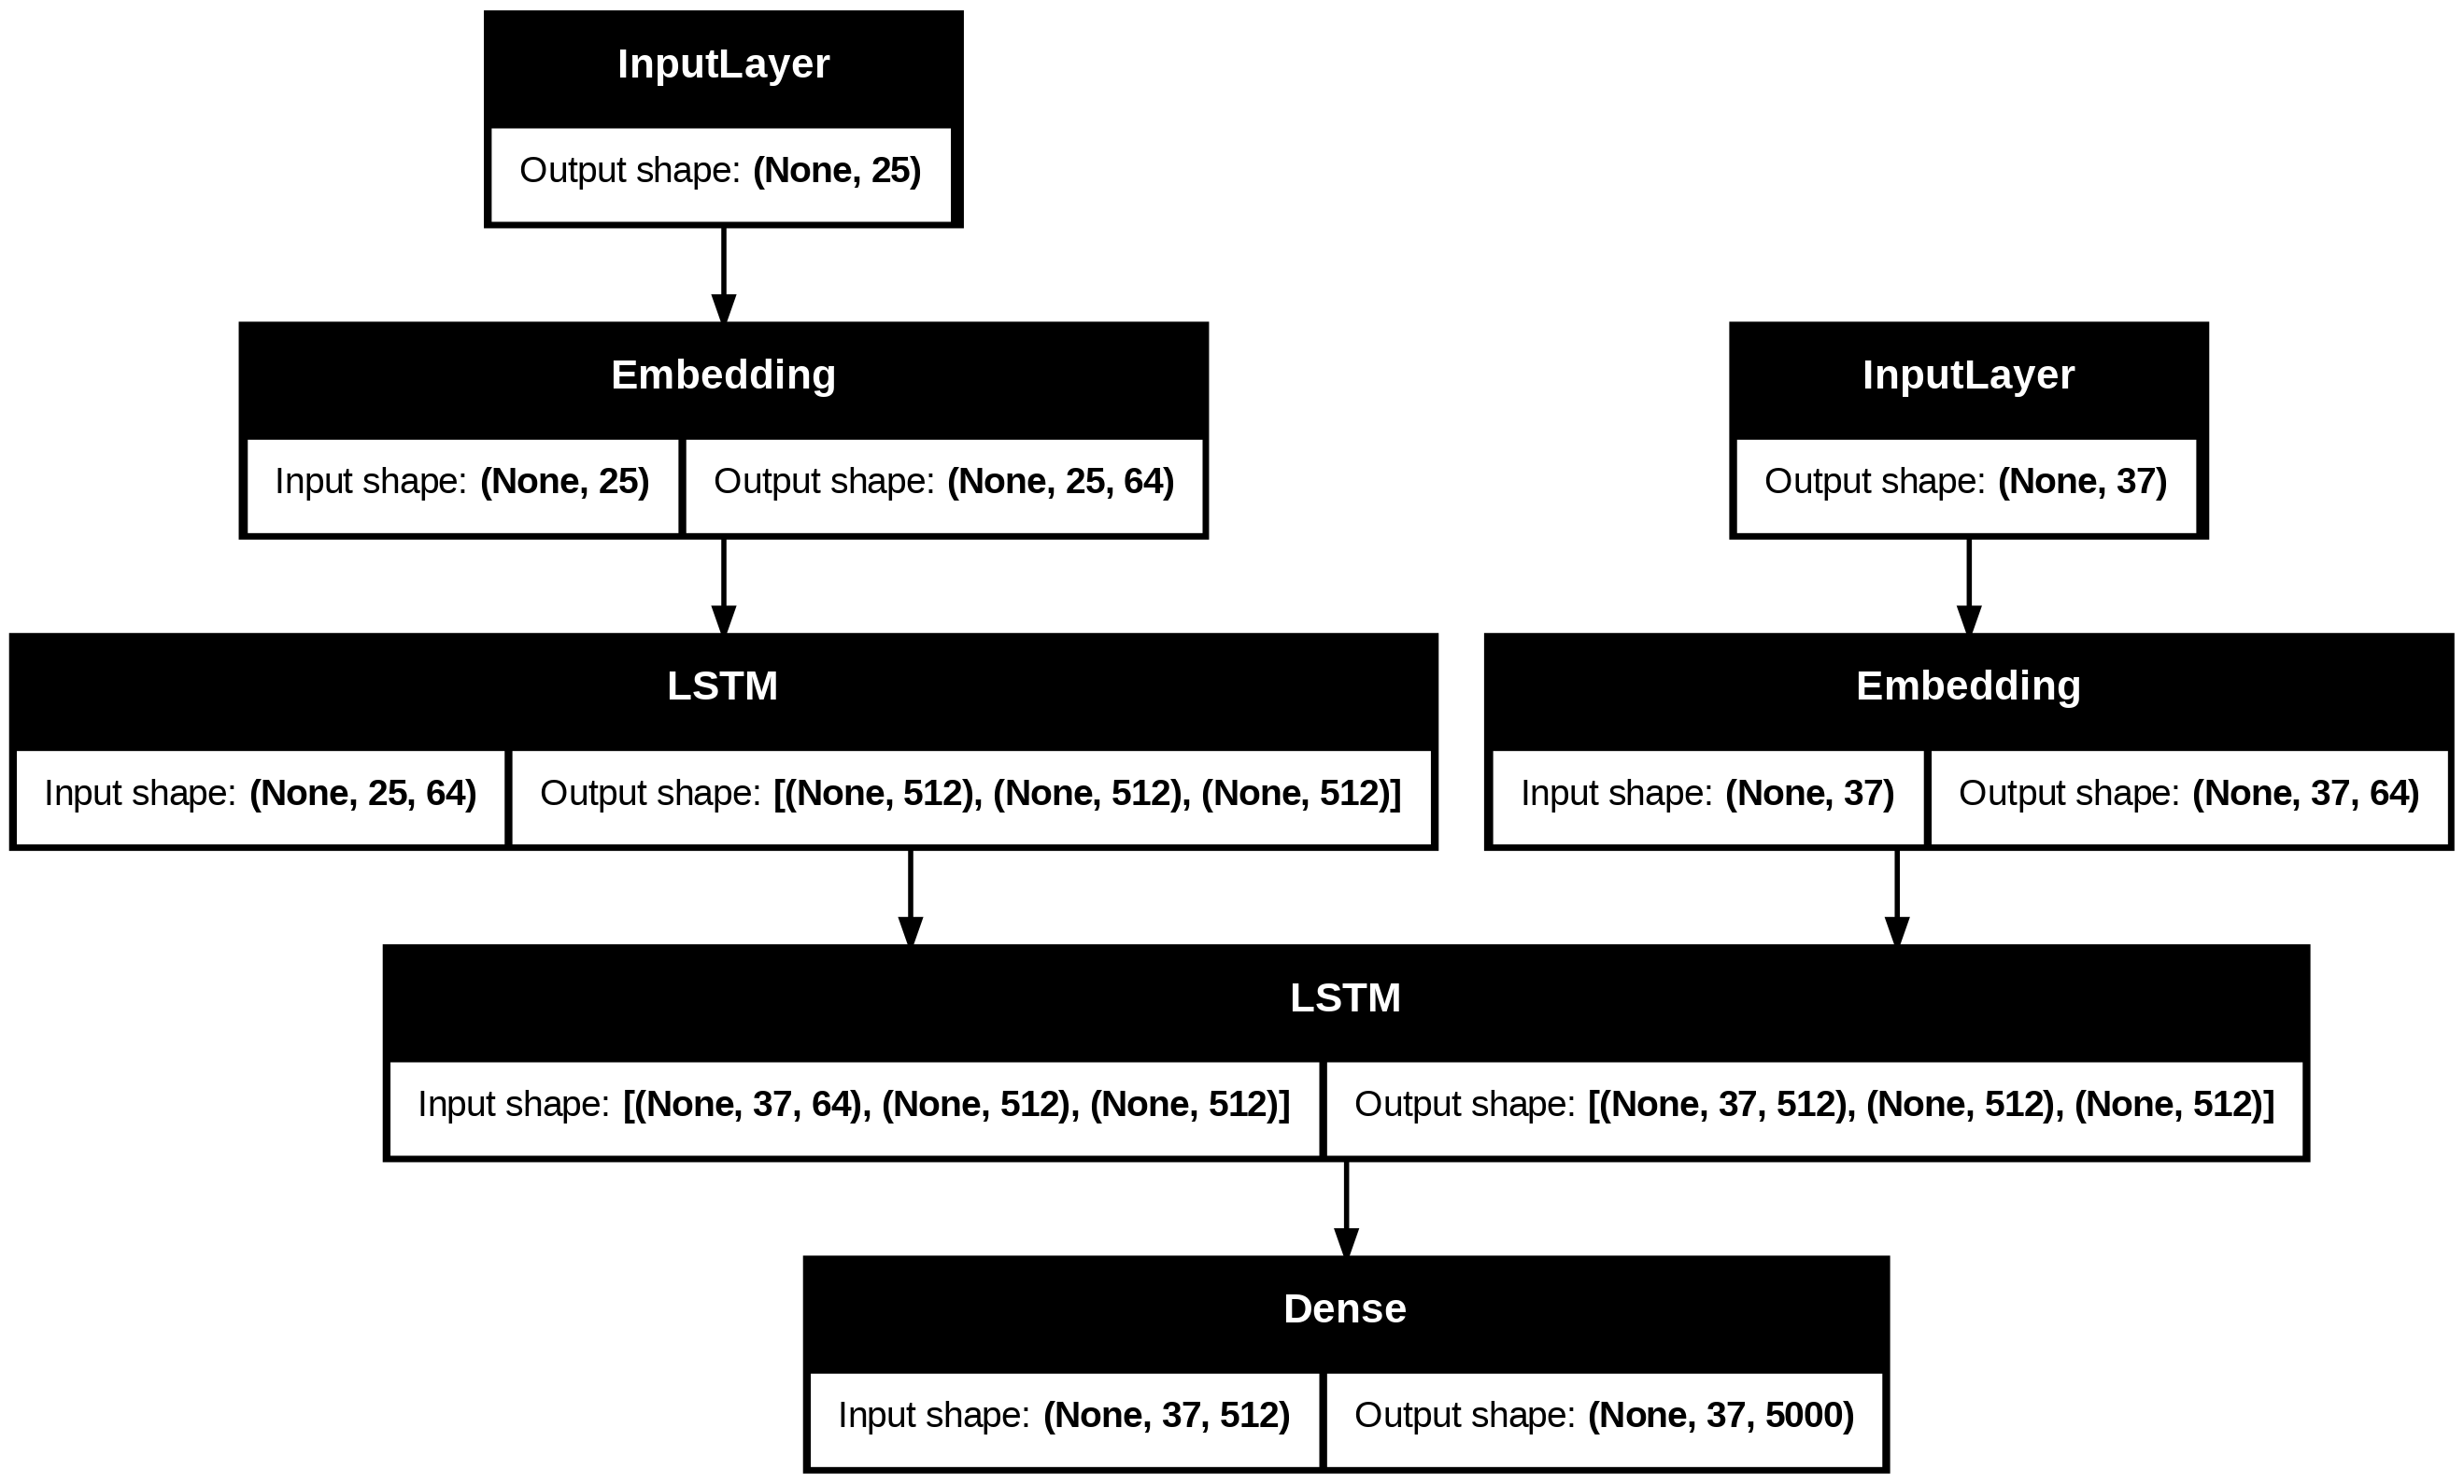

In [18]:
from tensorflow.keras.utils import plot_model

plot_model(decoder_teacher_forcing_model, show_shapes = True)

In [19]:
decoder_teacher_forcing_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

decoder_teacher_forcing_model.fit(
    [q_inputs_padded,a_inputs_padded],
    a_targets_padded,
    batch_size = 65,
    epochs = 100,
    validation_split = 0.2
)

Epoch 1/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.7665 - loss: 2.5498 - val_accuracy: 0.8054 - val_loss: 1.4515
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.8403 - loss: 1.1311 - val_accuracy: 0.8078 - val_loss: 1.3724
Epoch 3/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8419 - loss: 1.0668 - val_accuracy: 0.8105 - val_loss: 1.3423
Epoch 4/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8457 - loss: 1.0174 - val_accuracy: 0.8154 - val_loss: 1.3217
Epoch 5/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.8475 - loss: 0.9986 - val_accuracy: 0.8172 - val_loss: 1.3142
Epoch 6/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.8508 - loss: 0.9598 - val_accuracy: 0.8172 - val_loss: 1.3060
Epoch 7/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8509 - loss: 0.9461 - val_accuracy: 0.8193 - val_loss: 1.2941
Epoch 8/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.8554 - loss: 0.

In [20]:
# 모델 저장
decoder_teacher_forcing_model.save('decoder_teacher_forcing_model.keras')

In [28]:
# 모델 로드
from tensorflow.keras.models import load_model

decoder_teacher_forcing_model = load_model('decoder_teacher_forcing_model.keras')

##### 모델 추론

In [29]:
decoder_hidden_state = layers.Input(shape = (LATENT_DIM,))
decoder_cell_state = layers.Input(shape = (LATENT_DIM,))
decoder_states_inputs = [decoder_hidden_state, decoder_cell_state]

decoder_single_input = layers.Input(shape = (1,))

x= a_embedding_layer(decoder_single_input)

x, h, c = decoder_lstm(x, initial_state = decoder_states_inputs)
decoder_states = [h,c]

decoder_outputs = decoder_dense(x)

decoder_inference_model = models.Model(
    inputs = [decoder_single_input] + decoder_states_inputs,
    outputs = [decoder_outputs] + decoder_states
)

decoder_inference_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 64)     │    320,000 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 1, 512),  │  1,181,696 │ embedding_1[2][0… │
│                     │ (None, 512),      │            │ input_layer_4[0]… │
│                     │ (None, 512)]      │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 5000)   │  2,565,000 │ lstm_1[2][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,066,696 (15.51 MB)

 Trainable params: 4,066,696 (15.51 MB)

 Non-trainable params: 0 (0.00 B)

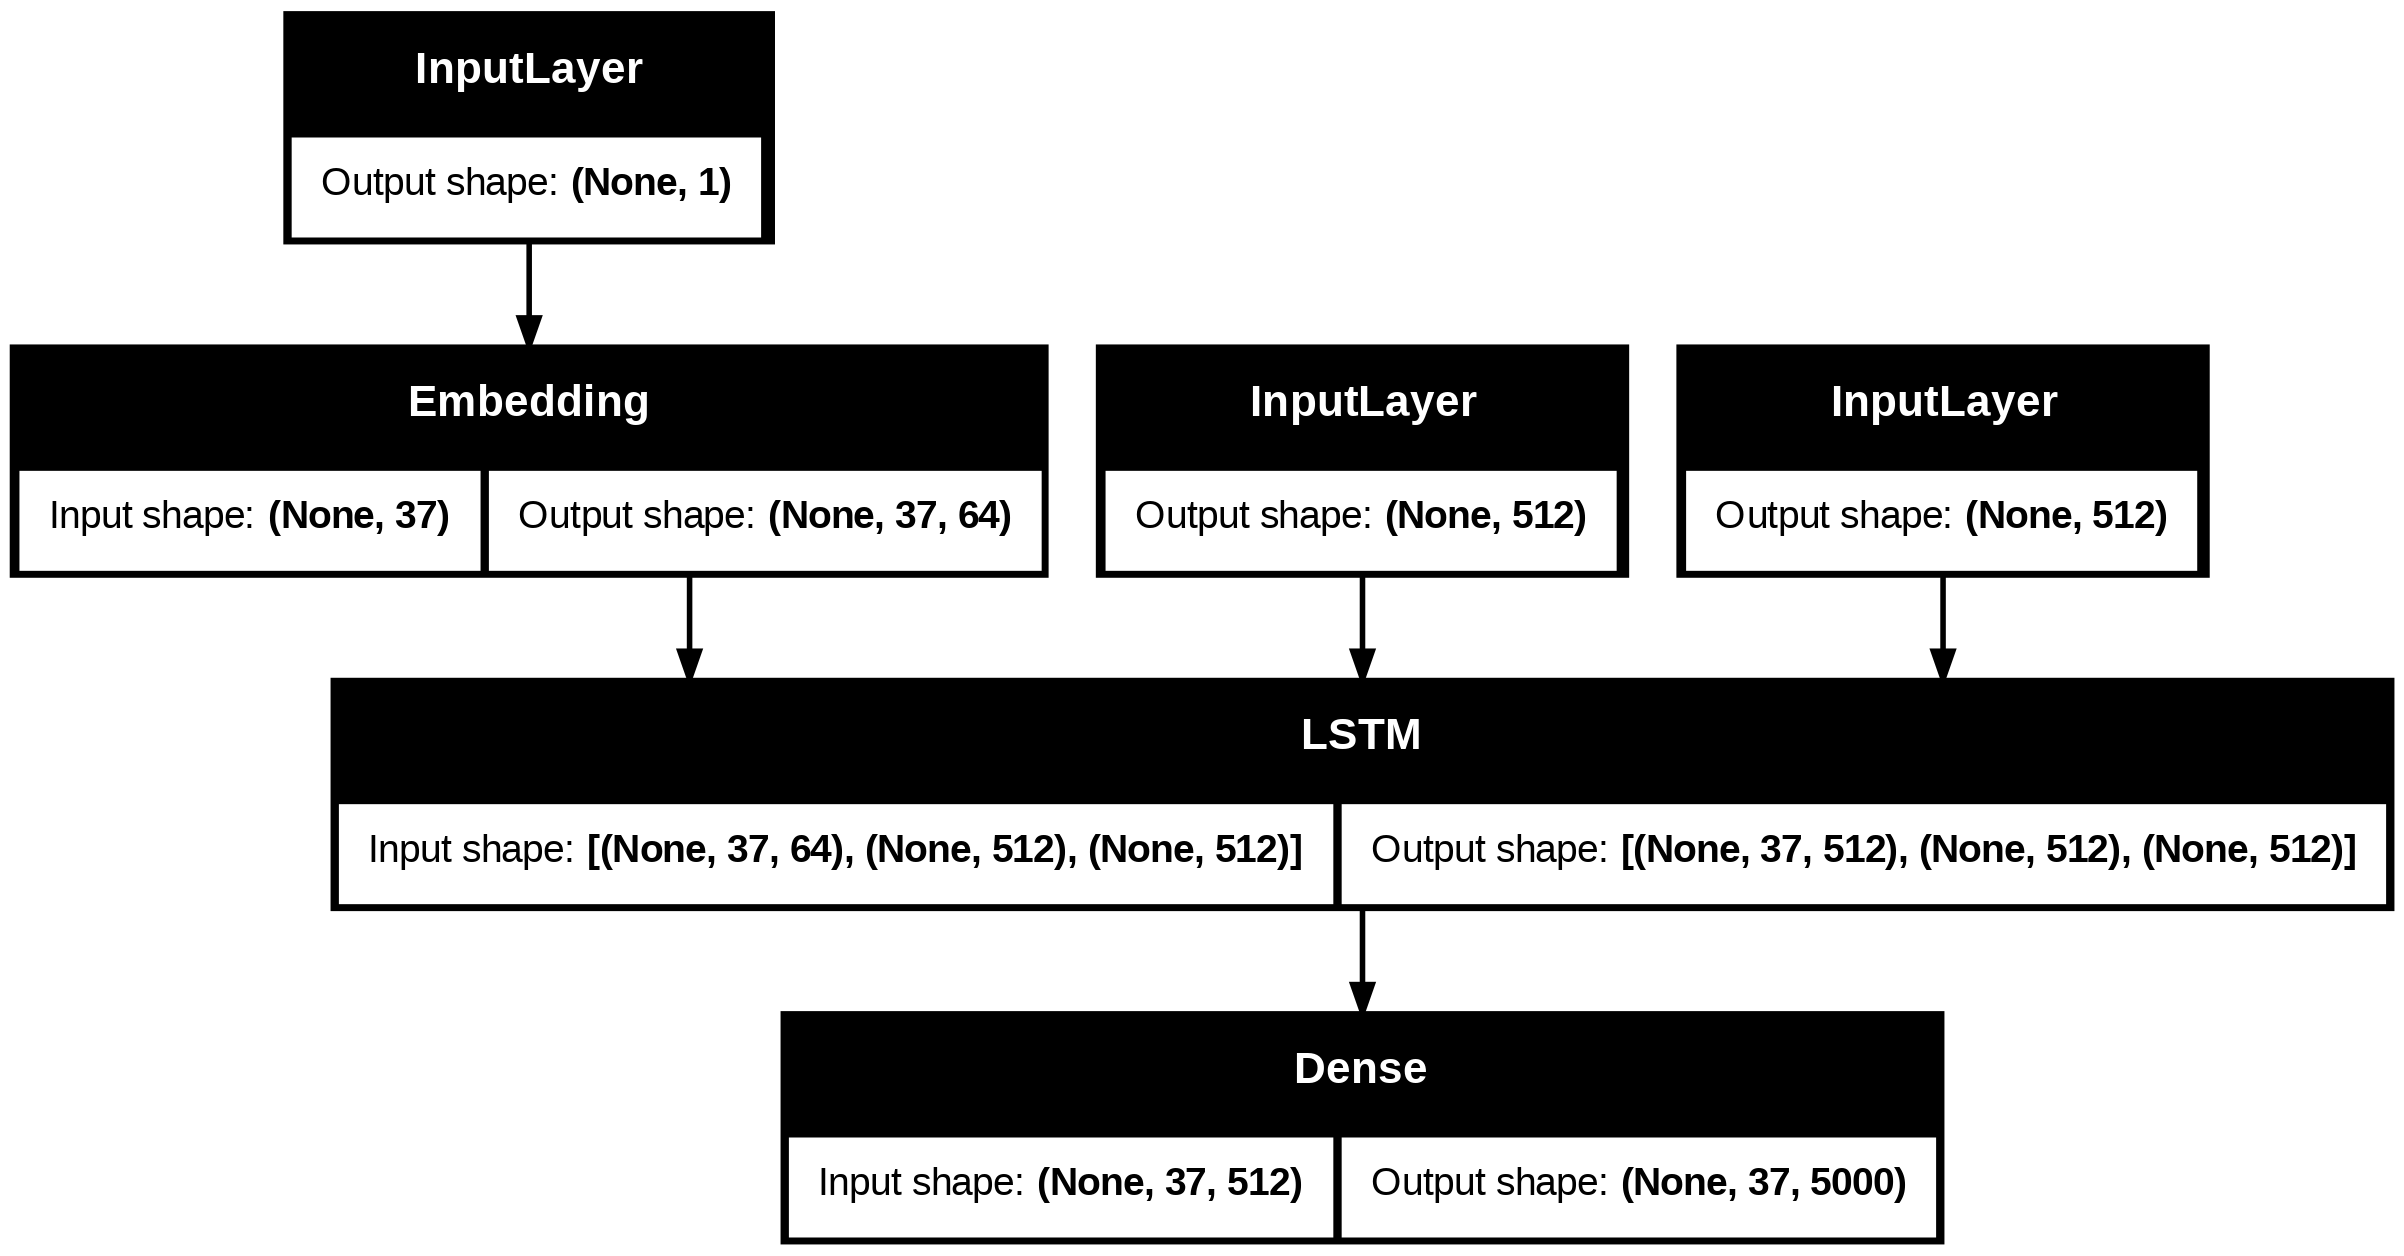

In [23]:
plot_model(decoder_inference_model, show_shapes = True)

**Decoder(추론 모델) 생성**

**추론 함수**

In [37]:
BOS_SP = sp.bos_id() if sp.bos_id() != -1 else sp.piece_to_id("<sos>")
EOS_SP = sp.eos_id() if sp.eos_id() != -1 else sp.piece_to_id("<eos>")
PAD_SP = sp.pad_id() if sp.pad_id() != -1 else -1  # 없으면 -1

# ===== 중요: 모델이 +1 시프트를 썼는지에 따라 OFFSET 설정 =====
OFFSET = 0   # 시프트 안 했으면 0, 시프트 했으면 1로 바꾸세요!

# SP ID <-> 모델 ID 매핑
def to_model_id(sp_id):    # SP → 모델
    return sp_id + OFFSET if sp_id != PAD_SP or OFFSET == 0 else 0

def to_sp_id(model_id):    # 모델 → SP
    return model_id - OFFSET if OFFSET == 1 else model_id

SOS_MODEL = to_model_id(BOS_SP)
EOS_MODEL = to_model_id(EOS_SP)
PAD_MODEL = 0 if OFFSET == 1 else to_model_id(PAD_SP)

def translate(input_seq):
    # input_seq: (1, L_src) 정수 ID (모델에 맞춘 ID: OFFSET 규칙에 일치해야 함)
    encoder_states_value = encoder_model.predict(input_seq)
    decoder_states_value = encoder_states_value
    # 디코더 시작 토큰 준비 (int32!)
    target_seq = np.array([[SOS_MODEL]], dtype='int32')

    out_sp_ids = []

    for _ in range(a_input_max_len):
        output_tokens, h, c = decoder_inference_model.predict([target_seq] + decoder_states_value)

        # 다음 토큰 선택 (greedy)
        pred_model_id = int(np.argmax(output_tokens[0, 0, :]))

        # 종료 조건
        if pred_model_id == EOS_MODEL:
            break

        # PAD/SOS는 최종 문장에 넣지 않음
        if pred_model_id != PAD_MODEL and pred_model_id != SOS_MODEL:
            out_sp_ids.append(to_sp_id(pred_model_id))  # 모델ID → SP ID로 복원해 저장

        # 다음 스텝 준비
        target_seq[0, 0] = pred_model_id
        decoder_states_value = [h, c]

    # SentencePiece로 자연스러운 문장 복원(공백 처리 자동)
    return sp.decode_ids(out_sp_ids)

##### 테스트

In [38]:
for _ in range(5):
  idx = np.random.choice(len(q_inputs_padded))
  input_seq = q_inputs_padded[idx : idx+1]
  output_sent = translate(input_seq)
  display('입력 영문 : ', q_text[idx])
  display('학습한 국문 : ', a_text_input[idx] )
  display('추론한 국문 : ', output_sent)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'입력 영문 : '

'8년 만났는데 어떻게 헤어져'

'학습한 국문 : '

'끝내는 게 힘들었을 거 같아요.'

'추론한 국문 : '

'여기까지였을 거예요.'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'입력 영문 : '

'사회에서도 좋은 사람 많이 만날 수 있을까?'

'학습한 국문 : '

'가려 가며 만나면 돼요.'

'추론한 국문 : '

'대하는 태도에 따라 다를 것 같아요.'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


'입력 영문 : '

'나 같은 사람은 동물 키우면 안되겠지'

'학습한 국문 : '

'아니길 바라요.'

'추론한 국문 : '

'잘 아시네요.'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


'입력 영문 : '

'짝남이 좋다고 했던 노래 이 새벽에 참 어울리는 노래야.'

'학습한 국문 : '

'부담스럽지 않는 선물을 생각해보세요.'

'추론한 국문 : '

'나쁜 생각 하지 마세요.'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


'입력 영문 : '

'심난한 하루'

'학습한 국문 : '

'마음이 복잡했나봐요.'

'추론한 국문 : '

'내일은 나은 하루이길 바랄게요.'

In [39]:
while True:
  user_input = input()
  if user_input == '종료':
    break
  user_ids = sp.encode(user_input, out_type=int)
  input_seq = pad_sequences([user_ids], maxlen = q_input_max_len, padding = 'pre')
  output_sent = translate(input_seq)
  print(f'Question : {user_input}')
  print(f'Answer : {output_sent}')

여름 너무 덥다
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Question : 여름 너무 덥다
Answer : 차가운 음료 너무 많이 마시면 아니 되어요
지금 뭐할까?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Question : 지금 뭐할까?
Answer : 킁킁
공부가 너무 어려워
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Question : 공부가 너무 어려워
Answer : 적당히 드세요.
너무 힘들어
1/1 ━

##### 간단한 Chatbot 구현
1. 사용자의 입력을 받아 (처리 후)
2. 추론 함수에 전달해서
3. 응답을 출력
4. 1 ~ 3 '종료' 전까지 반복